In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [3]:
# transform_characteristics = transforms.Compose([transforms.Resize(255),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor()])
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

The dataloader is compoosed of 6 batches, each of them of size 32 making a total of: 192, which is enough for storing the 179 images that we have in the positive dataset

In [4]:
print(len(dataloader))

6


In [5]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\Alex\.conda\envs\tfm\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0007) tensor(1.)


The problem with the above is that we expected the min value to be 0 according to a previous example.

    SOLVED: For the moment, we changed the order in which the operations of the transforms were applied. This resulted in what we initially expected: The min tensor value to be 0 and the max tensor value equals 1.


The following, is a way of formatting the image to be able to show them:

Converting the images to numpy to be able to show them

In [6]:
imgs = images.detach().numpy()
# imgs = images.numpy()     #We could also use this command to convert it to numpy array. Not sure about the differences
print(type(imgs))

<class 'numpy.ndarray'>


In [7]:
single_img = imgs[0]
img_to_show = single_img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))

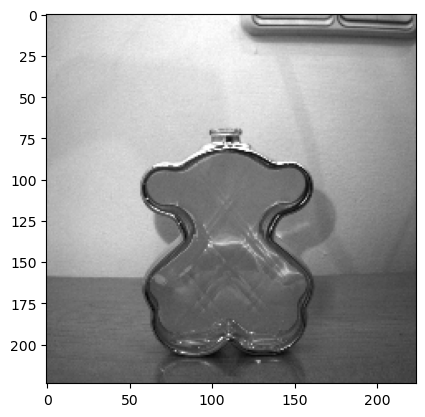

In [8]:
plt.imshow(new_img_to_show)

Aux function for converting an image saved in form of a tensor to the appropriate format for displaying it with plt.show()

In [9]:
def convert_for_display(img_in_tensor_type):
    img = img_in_tensor_type.detach().numpy()
    img_to_show = img * 255
    img_to_show = img_to_show.astype("uint8")
    one_channel_img = img_to_show[0]
    new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))
    return new_img_to_show

In [10]:
print(images.shape)

torch.Size([32, 3, 224, 224])


In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        # 32, 3, 224, 224
        input_channels = 3              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5

        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # input image channels, output channels, kernel size (filter). Dimension rseult: -> N, 110, 44, 44
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), # -> N, 225, 8, 8
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # -> N, 450, 1, 1
        )
        
        # N , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8),  # -> 32, 225, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), 
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # N, 3, 224, 224
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [12]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [ ]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in dataloader:     # This iterates over the batches of images.
        
        # Forward pass
        recon = model(img)          # The entire batch of images is passed to the model
        loss = criterion(recon, img)

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Saving and loading a model

In [13]:
filepath = "../../../BottlesAnomalies_TFM/models/pytorchModels/PytorchModel2"


In [ ]:
torch.save(model.state_dict(), filepath)

In [14]:
# For loading the model 
model.load_state_dict(torch.load(filepath))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [15]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

Original Images


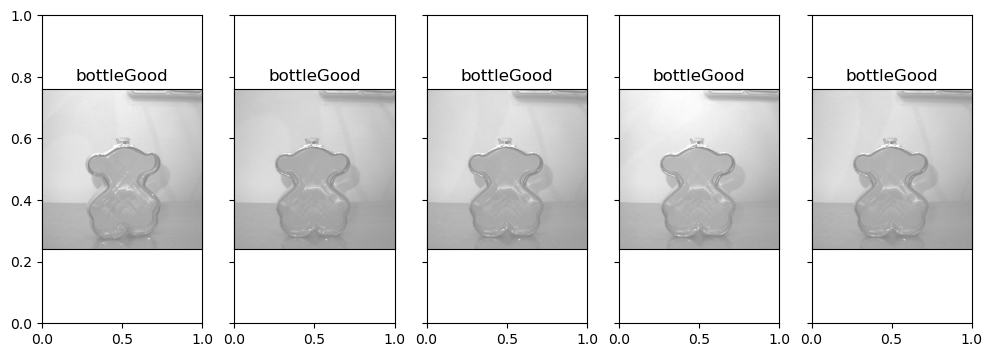

Reconstructed Images


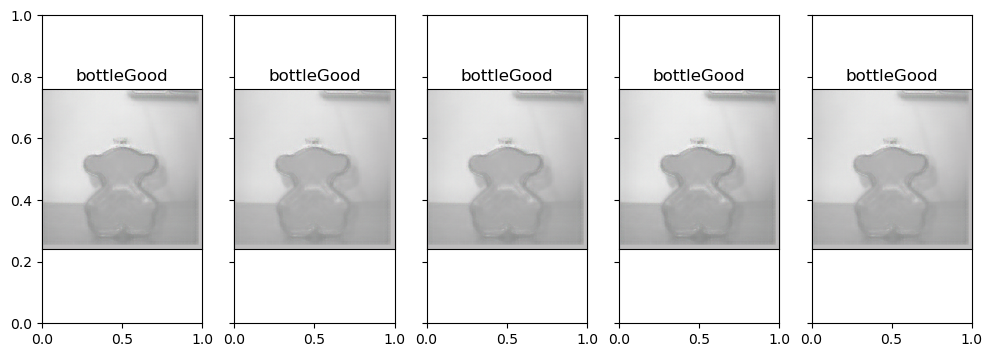

In [16]:
#Batch of test images
dataiter = iter(dataloader)
images, labels = next(dataiter)

#Sample outputs
output = model(images)

images = images.numpy()

output = output.view(32, 3, 224, 224)
output = output.detach().numpy()

#Define the image classes
classes = ['bottleGood']

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

# Quantifying the reconstruction error

Performing step by step tests. Considering only the first image of the dataset and obtaining its reconstruction.

In [17]:

print("The input data considering only one sample. Not a batch of samples")
X = dataset[0]
image_in_tensor = X[0]
print("The images are stored in a variable of type: ", type(image_in_tensor))
print("The min and max tensor values of the input is: ", torch.min(image_in_tensor), torch.max(image_in_tensor))
print("\n")
print("The reconstructed data onsidering only one sample. Not a batch of samples")
with torch.no_grad():       # Because gradients will not be computed
    Y = model(image_in_tensor)
print("The recontructed images are stored in a variable of type: ", type(Y))
print("The min and max tensor values of the reconstruction is: ", torch.min(Y), torch.max(Y))


The input data considering only one sample. Not a batch of samples
The images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the input is:  tensor(0.0199) tensor(1.)


The reconstructed data onsidering only one sample. Not a batch of samples
The recontructed images are stored in a variable of type:  <class 'torch.Tensor'>
The min and max tensor values of the reconstruction is:  tensor(0.0536) tensor(0.9660)


Making sure that "image_in_tensor" is actually the image of the dataset.


In [18]:
print("The shape of the image is: ", image_in_tensor.shape)
print("The type of the image is: ", type(image_in_tensor))


The shape of the image is:  torch.Size([3, 224, 224])
The type of the image is:  <class 'torch.Tensor'>


Displaying its content:


<class 'numpy.ndarray'>


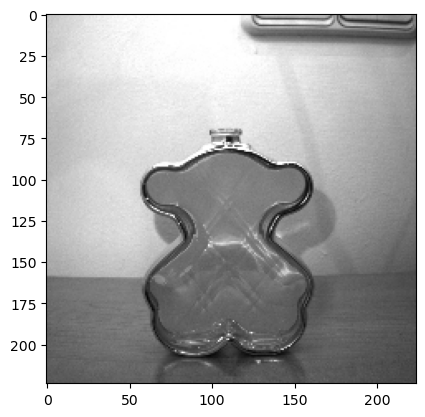

In [19]:
img = image_in_tensor.detach().numpy()
print(type(img))

img_to_show = img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))
plt.imshow(new_img_to_show)


Showing the shape of the reconstructed image:


In [20]:
print("The shape of the image is: ", Y.shape)
print("The type of the image is: ", type(Y))


The shape of the image is:  torch.Size([3, 224, 224])
The type of the image is:  <class 'torch.Tensor'>


Displaying the reconstructed image:

<class 'numpy.ndarray'>


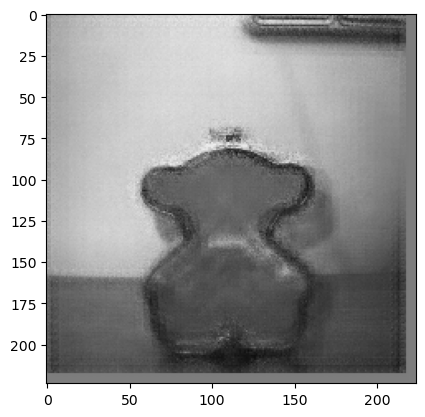

In [21]:
img = Y.detach().numpy()
print(type(img))

img_to_show = img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))
plt.imshow(new_img_to_show)

From above, we can be sure that the reconstructed and input original images are handled as expected. However, one detail to notice in the reconstructed image, is the fact that it seems to be filling some pixels with some sort of padding, see the bottom and right part of the reconstructed image. 

Computing the reconstruction error of the first image in the dataset

In [22]:
err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y))
print(err)
print(type(err))

err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
print(err)
print(type(err))

tensor(1870.1310)
<class 'torch.Tensor'>
1870.1309814453125
<class 'float'>


Above error sum is the result of the three channels of the image. Let's see the error computation of each of the channels

In [23]:
err = torch.sum((image_in_tensor[0]-Y[0])*(image_in_tensor[0]-Y[0]))
print(err)
err2 = torch.sum((image_in_tensor[1]-Y[1])*(image_in_tensor[1]-Y[1]))
print(err2)
err3 = torch.sum((image_in_tensor[2]-Y[2])*(image_in_tensor[2]-Y[2]))
print(err3)

tensor(634.1509)
tensor(612.4442)
tensor(623.5360)


In [24]:
print(err+err2+err3)

tensor(1870.1311)


For the moment, the reconstruction error is not being divided by the number of pixels of the image, as it was done in the other reference program for computing this value. We will work in this way for the moment.

Performing the computation of the reconstruction error of all the images in the dataset

In [25]:
result_lst = []
# n_features = len(data_ds[0])  # 65
for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 1870.1309814453125), (1, 992.2857666015625), (2, 1207.613037109375), (3, 583.0374145507812), (4, 543.7574462890625), (5, 583.98291015625), (6, 660.8671875), (7, 681.27001953125), (8, 617.3809814453125), (9, 611.3062133789062), (10, 584.59326171875), (11, 552.8016967773438), (12, 993.708251953125), (13, 934.829833984375), (14, 715.47509765625), (15, 814.0592041015625), (16, 567.78759765625), (17, 906.7799072265625), (18, 741.2510986328125), (19, 1295.107421875), (20, 1539.08837890625), (21, 1507.368408203125), (22, 1086.2149658203125), (23, 840.5142211914062), (24, 560.8550415039062), (25, 650.840576171875), (26, 1026.470947265625), (27, 1013.017822265625), (28, 1251.8984375), (29, 1178.779052734375), (30, 628.6134643554688), (31, 623.809814453125), (32, 1007.3638305664062), (33, 1034.832275390625), (34, 946.03369140625), (35, 802.9981689453125), (36, 950.668212890625), (37, 1185.53564453125), (38, 1330.7833251953125), (39, 1489.2320556640625), (40, 667.955810546875), (41, 785.9614

In [27]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(179, 1904.59423828125), (0, 1870.1309814453125), (120, 1615.70751953125), (146, 1551.40185546875), (155, 1546.7841796875), (20, 1539.08837890625), (176, 1531.89111328125), (168, 1530.402587890625), (21, 1507.368408203125), (39, 1489.2320556640625), (177, 1488.2724609375), (175, 1462.991943359375), (137, 1408.467041015625), (165, 1405.967041015625), (178, 1404.1558837890625), (163, 1344.7010498046875), (38, 1330.7833251953125), (164, 1301.61572265625), (167, 1296.444580078125), (19, 1295.107421875), (169, 1294.58935546875), (161, 1294.2825927734375), (145, 1256.85546875), (162, 1256.5208740234375), (28, 1251.8984375), (144, 1250.8289794921875), (142, 1247.7957763671875), (143, 1244.15380859375), (141, 1235.64306640625), (60, 1226.6270751953125), (80, 1226.6270751953125), (166, 1224.8387451171875), (147, 1222.36376953125), (140, 1209.918212890625), (2, 1207.613037109375), (116, 1207.40087890625), (158, 1207.157470703125), (160, 1203.247314453125), (170, 1197.226318359375), (139, 1192.2

The image that resulted in the highest reconstruction error is:

In [ ]:
(idx,err) = result_lst[0]

X = dataset[idx]
image_in_tensor = X[0]
with torch.no_grad():       # Because gradients will not be computed
    Y = model(image_in_tensor)

Y_img = Y.detach().numpy()
X_img = image_in_tensor.detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("original image")
imshow(X_img)
plt.subplot(122)
plt.title("reconstructed image")
imshow(Y_img)


Using another function for displaying the images, for better appreciation of the image

In [ ]:
(idx,err) = result_lst[0]

X = dataset[idx]
image_in_tensor = X[0]
with torch.no_grad():       # Because gradients will not be computed
    Y = model(image_in_tensor)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(convert_for_display(image_in_tensor))
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(convert_for_display(Y))
plt.show()

displaying the image that resulted in the lowest reconstruction error:

In [ ]:
(idx,err) = result_lst[-1]

X = dataset[idx]
image_in_tensor = X[0]
with torch.no_grad():       # Because gradients will not be computed
    Y = model(image_in_tensor)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(convert_for_display(image_in_tensor))
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(convert_for_display(Y))
plt.show()